In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image

## Unzip the two Dataset

In [3]:
import zipfile

# Define dataset paths in Google Drive
disease_dataset_zip = '/content/drive/MyDrive/SDP/Paddy Leaf Disease Images.zip'
stage_dataset_zip = '/content/drive/My Drive/SDP/Paddy leaf stage Images.zip'

# Extract datasets
with zipfile.ZipFile(disease_dataset_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/disease_dataset')

with zipfile.ZipFile(stage_dataset_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/stage_dataset')

## Increasing the size of the Stage Dataset by Data Augmentation

In [4]:
stage_dataset_path = '/content/stage_dataset/Paddy leaf stage Images'
# Parameters
img_height, img_width = 128, 128

# Augmentation settings
datagen = ImageDataGenerator(
    rotation_range=20,  # Random rotation
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom
    horizontal_flip=True,  # Horizontal flip
    fill_mode='nearest'  # Filling empty pixels
)

# Function to augment and save images
def augment_and_save_images(folder_path, target_count):
    # Get all images in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    current_count = len(image_files)
    images_needed = target_count - current_count

    print(f"Augmenting {images_needed} images for folder: {folder_path}")

    # Load images and apply augmentation
    for img_file in image_files:
        if images_needed <= 0:
            break

        img_path = os.path.join(folder_path, img_file)
        img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        # Generate augmented images
        aug_iter = datagen.flow(img_array, batch_size=1)
        for i in range(images_needed):
            aug_img = next(aug_iter)[0].astype(np.uint8)  # Get augmented image
            aug_img = Image.fromarray(aug_img)

            # Save the augmented image
            aug_img.save(os.path.join(folder_path, f"aug_{i}_{img_file}"))

            images_needed -= 1
            if images_needed <= 0:
                break

# Augment and save images for 6x in each folder
for stage_folder in os.listdir(stage_dataset_path):
    stage_folder_path = os.path.join(stage_dataset_path, stage_folder)
    if os.path.isdir(stage_folder_path):
        current_images = len([f for f in os.listdir(stage_folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
        augment_and_save_images(stage_folder_path, target_count=current_images * 6)

Augmenting 580 images for folder: /content/stage_dataset/Paddy leaf stage Images/5
Augmenting 620 images for folder: /content/stage_dataset/Paddy leaf stage Images/4
Augmenting 790 images for folder: /content/stage_dataset/Paddy leaf stage Images/2
Augmenting 810 images for folder: /content/stage_dataset/Paddy leaf stage Images/3


## Preprocess and load both dataset

In [5]:

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Parameters
img_height, img_width = 128, 128

# Function to load and preprocess data
def load_data(dataset_path):
    images, labels = [], []
    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
                img = tf.keras.utils.img_to_array(img) / 255.0
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

# Dataset paths
disease_dataset_path = '/content/disease_dataset/Paddy Leaf Disease Images'
stage_dataset_path = '/content/stage_dataset/Paddy leaf stage Images'

# Load datasets
print("Loading disease dataset...")
disease_images, disease_labels = load_data(disease_dataset_path)
print("Loading stage dataset...")
stage_images, stage_labels = load_data(stage_dataset_path)

# Encode labels
le_disease = LabelEncoder()
disease_labels_encoded = le_disease.fit_transform(disease_labels)
disease_labels_encoded = to_categorical(disease_labels_encoded)

le_stage = LabelEncoder()
stage_labels_encoded = le_stage.fit_transform(stage_labels)
stage_labels_encoded = to_categorical(stage_labels_encoded)

Loading disease dataset...
Loading stage dataset...


## Split the both dataset into train(80%), validation(10%) and test(10%)

In [6]:
# Split datasets for training, validation, and testing
disease_train_x, disease_test_x, disease_train_y, disease_test_y = train_test_split(
    disease_images, disease_labels_encoded, test_size=0.2, random_state=42)

disease_val_x, disease_test_x, disease_val_y, disease_test_y = train_test_split(
    disease_test_x, disease_test_y, test_size=0.5, random_state=42)

stage_train_x, stage_test_x, stage_train_y, stage_test_y = train_test_split(
    stage_images, stage_labels_encoded, test_size=0.2, random_state=42)

stage_val_x, stage_test_x, stage_val_y, stage_test_y = train_test_split(
    stage_test_x, stage_test_y, test_size=0.5, random_state=42)

# Print dataset sizes
print("Disease Dataset:")
print(f"Training images: {len(disease_train_x)}")
print(f"Validation images: {len(disease_val_x)}")
print(f"Testing images: {len(disease_test_x)}")

print("\nStage Dataset:")
print(f"Training images: {len(stage_train_x)}")
print(f"Validation images: {len(stage_val_x)}")
print(f"Testing images: {len(stage_test_x)}")

Disease Dataset:
Training images: 5536
Validation images: 692
Testing images: 692

Stage Dataset:
Training images: 2688
Validation images: 336
Testing images: 336


## Built a Neural Network model for train the stage Dataset and Evaluation

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
# Build disease classification model
def build_stage_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(stage_labels_encoded.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

stage_model = build_stage_model()
stage_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Build the stage classification model

print("Training stage classification model...")
stage_history = stage_model.fit(stage_train_x, stage_train_y,
                                    validation_data=(stage_val_x, stage_val_y),
                                    epochs=10, batch_size=10)

Training stage classification model...
Epoch 1/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.6268 - loss: 0.9097 - val_accuracy: 0.9286 - val_loss: 0.2047
Epoch 2/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8850 - loss: 0.3345 - val_accuracy: 0.9286 - val_loss: 0.1921
Epoch 3/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9099 - loss: 0.2822 - val_accuracy: 0.9375 - val_loss: 0.1718
Epoch 4/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9270 - loss: 0.2058 - val_accuracy: 0.9345 - val_loss: 0.1819
Epoch 5/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9243 - loss: 0.1988 - val_accuracy: 0.9405 - val_loss: 0.2343
Epoch 6/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9340 - loss: 0.1797 - val_accuracy: 0.9345 - val_loss: 0.2076
Epoch 7/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9420 - loss: 0.1737 - val_accuracy: 0.9405 - val_loss: 0.1971
Epoch 8/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy:

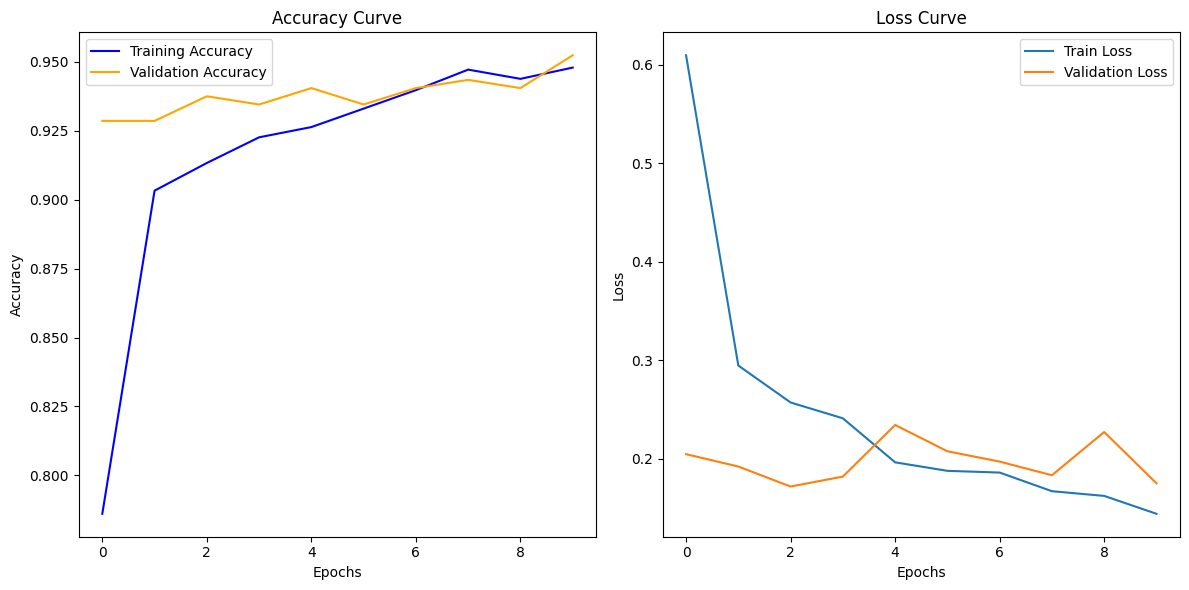

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot Loss Curves
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(stage_history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(stage_history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(stage_history.history['loss'], label='Train Loss')
plt.plot(stage_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = stage_model.evaluate(stage_test_x, stage_test_y, verbose=0)

# Display the test dataset results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.9405
Test Loss: 0.1759


In [ ]:
stage_model.save("stage_model.h5")

In [ ]:
stage_path = '/content/drive/MyDrive/SDP/models/stage_model.h5'

stage_model.save(stage_path)

## Train a CNN model and multiple Pretrained models(VGG16, ResNet50, InceptionV3, MobileNetV2) on the Diseease Dataset and Evaluation

In [ ]:
def build_cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(disease_labels_encoded.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_cnn_model()

In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2

def build_pretrained_model(base_model):
    base_model.trainable = False  # Freeze the base model layers
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(disease_labels_encoded.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Pretrained model instances
vgg16_model = build_pretrained_model(VGG16(input_shape=(128, 128, 3), include_top=False, weights='imagenet'))
resnet_model = build_pretrained_model(ResNet50(input_shape=(128, 128, 3), include_top=False, weights='imagenet'))
inception_model = build_pretrained_model(InceptionV3(input_shape=(128, 128, 3), include_top=False, weights='imagenet'))
mobilenet_model = build_pretrained_model(MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet'))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Train models
cnn_history = cnn_model.fit(disease_train_x, disease_train_y,
                            validation_data=(disease_val_x, disease_val_y),
                            epochs=20, batch_size=32)

vgg16_history = vgg16_model.fit(disease_train_x, disease_train_y,
                                validation_data=(disease_val_x, disease_val_y),
                                epochs=20, batch_size=32)

resnet_history = resnet_model.fit(disease_train_x, disease_train_y,
                                  validation_data=(disease_val_x, disease_val_y),
                                  epochs=20, batch_size=32)

inception_history = inception_model.fit(disease_train_x, disease_train_y,
                                        validation_data=(disease_val_x, disease_val_y),
                                        epochs=20, batch_size=32)

mobilenet_history = mobilenet_model.fit(disease_train_x, disease_train_y,
                                        validation_data=(disease_val_x, disease_val_y),
                                        epochs=20, batch_size=32)

Epoch 1/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.3778 - loss: 1.4828 - val_accuracy: 0.5780 - val_loss: 0.9702
Epoch 2/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6601 - loss: 0.8653 - val_accuracy: 0.7630 - val_loss: 0.6083
Epoch 3/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7503 - loss: 0.6521 - val_accuracy: 0.8078 - val_loss: 0.5018
Epoch 4/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7827 - loss: 0.5480 - val_accuracy: 0.7775 - val_loss: 0.5361
Epoch 5/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8141 - loss: 0.4986 - val_accuracy: 0.8699 - val_loss: 0.4008
Epoch 6/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8547 - loss: 0.3966 - val_accuracy: 0.8280 - val_loss: 0.4672
Epoch 7/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8557 - loss: 0.3710 - val_accuracy: 0.8598 - val_loss: 0.3713
Epoch 8/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8896 - loss: 0.2946 - val_accu

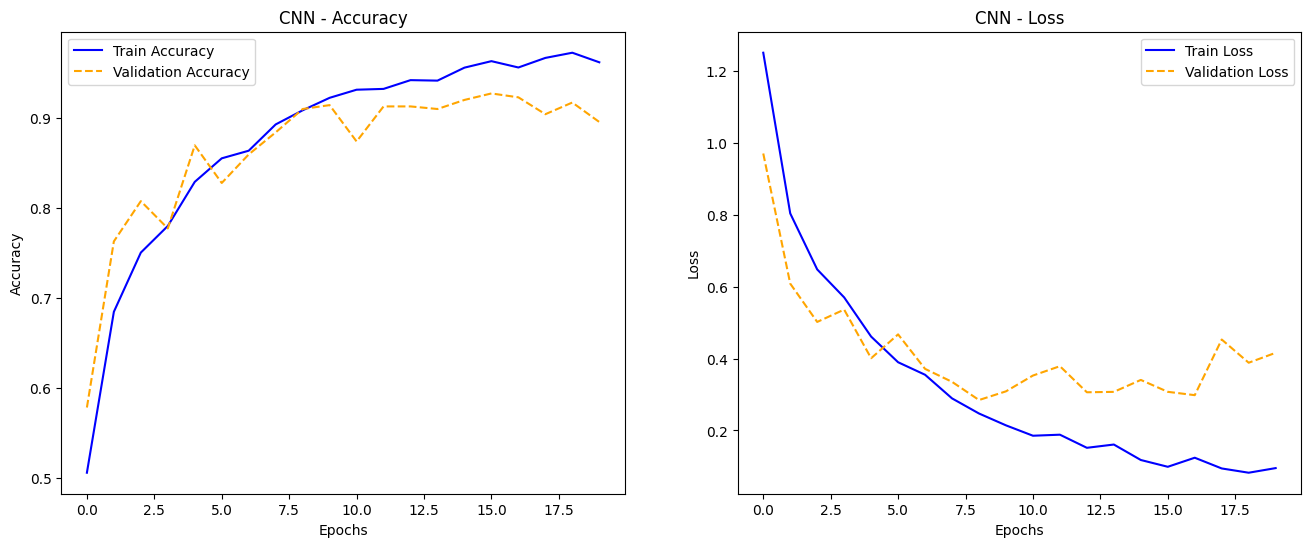

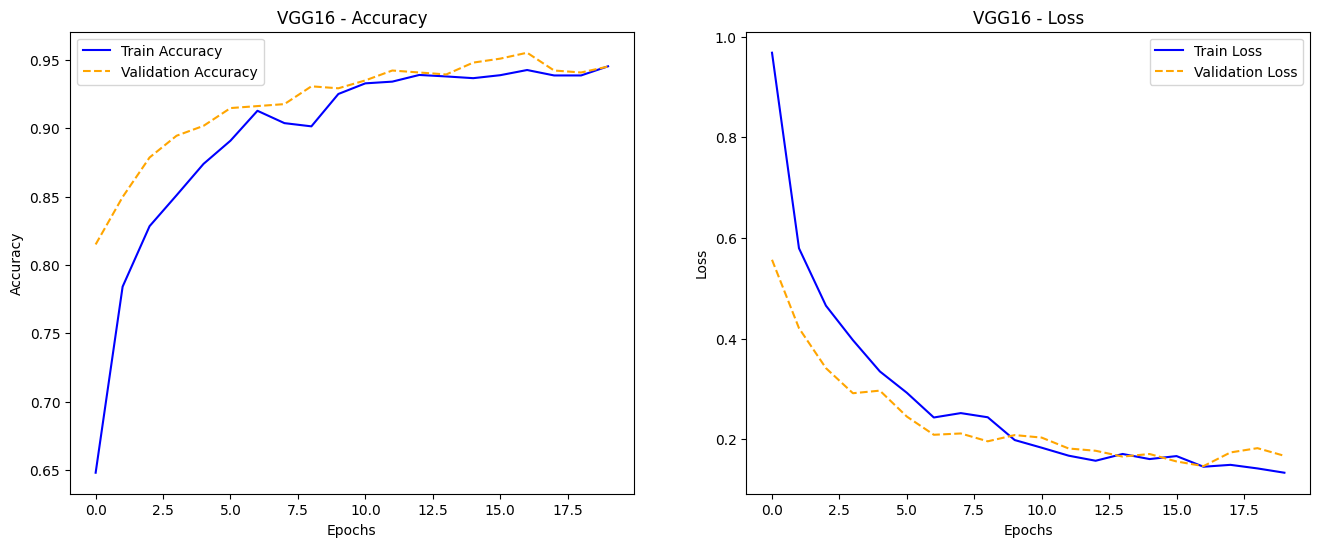

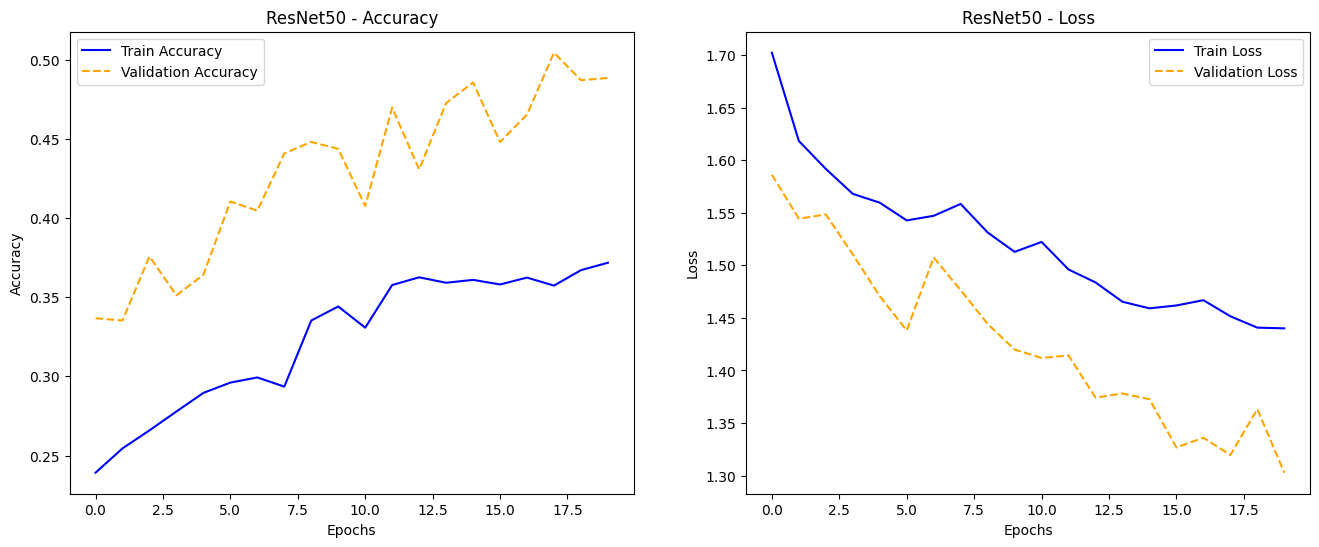

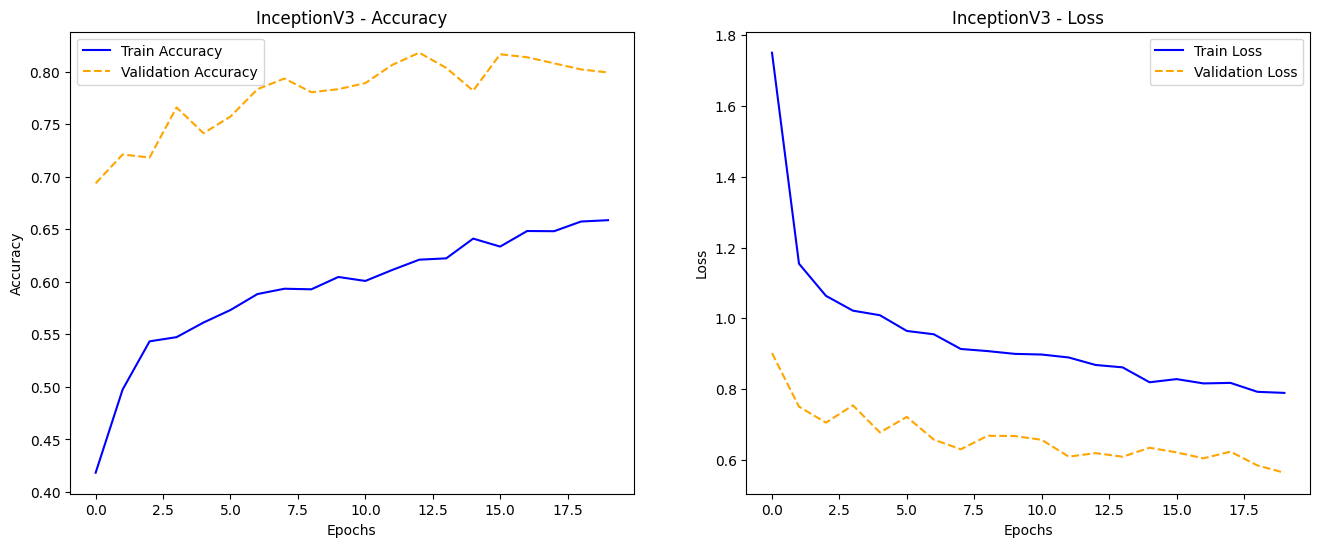

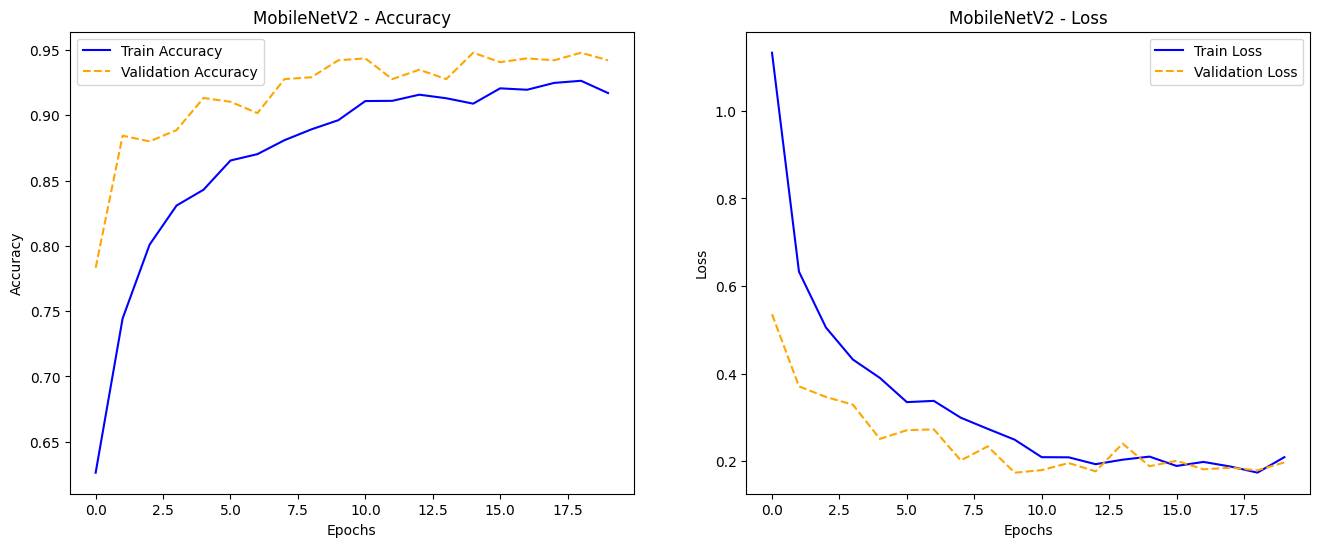

In [ ]:
import matplotlib.pyplot as plt

def display_training_metrics(models_histories, model_names):
      for history, name in zip(models_histories, model_names):
          # Create a new figure for each model
          plt.figure(figsize=(16, 6))

          # Plot training and validation accuracy
          plt.subplot(1, 2, 1)
          plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
          plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--', color='orange')
          plt.title(f'{name} - Accuracy')
          plt.xlabel('Epochs')
          plt.ylabel('Accuracy')
          plt.legend()

          # Plot training and validation loss
          plt.subplot(1, 2, 2)
          plt.plot(history.history['loss'], label='Train Loss', color='blue')
          plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--', color='orange')
          plt.title(f'{name} - Loss')
          plt.xlabel('Epochs')
          plt.ylabel('Loss')
          plt.legend()

# Combine histories and names
histories = [cnn_history, vgg16_history, resnet_history, inception_history, mobilenet_history]
model_names = ['CNN', 'VGG16', 'ResNet50', 'InceptionV3', 'MobileNetV2']

# Display training metrics
display_training_metrics(histories, model_names)

### Save the trained models

In [ ]:
cnn_model.save("models/cnn_model.h5")
vgg16_model.save("models/vgg16_model.h5")
resnet_model.save("models/resnet50_model.h5")
inception_model.save("models/inceptionv3_model.h5")
mobilenet_model.save("models/mobilenetv2_model.h5")

In [ ]:
cnn_path = '/content/drive/MyDrive/SDP/models/cnn_model.h5'
vgg16_path = '/content/drive/MyDrive/SDP/models/vgg16_model.h5'
resnet50_path = '/content/drive/MyDrive/SDP/models/resnet50_model.h5'
inceptionv3_path = '/content/drive/MyDrive/SDP/models/inceptionv3_model.h5'
mobilenetv2_path = '/content/drive/MyDrive/SDP/models/mobilenetv2_model.h5'


cnn_model.save(cnn_path)
vgg16_model.save(vgg16_path)
resnet_model.save(resnet50_path)
inception_model.save(inceptionv3_path)
mobilenet_model.save(mobilenetv2_path)

### Apply ensemble(Avg. voting) technique

In [16]:
# Load disease classification models (ensemble models)
disease_model_paths = [
    "/content/drive/MyDrive/SDP/models/cnn_model.h5",
    "/content/drive/MyDrive/SDP/models/vgg16_model.h5",
    "/content/drive/MyDrive/SDP/models/resnet50_model.h5",
    "/content/drive/MyDrive/SDP/models/inceptionv3_model.h5",
    "/content/drive/MyDrive/SDP/models/mobilenetv2_model.h5"
]

# Load the models
cnn_model = load_model(disease_model_paths[0])
vgg16_model = load_model(disease_model_paths[1])
resnet_model = load_model(disease_model_paths[2])
inception_model = load_model(disease_model_paths[3])
mobilenet_model = load_model(disease_model_paths[4])

# Load models and compile them explicitly
disease_models = [load_model(model_path, compile=False) for model_path in disease_model_paths]
for model in disease_models:
    model.compile()

print("Models loaded successfully!")

Models loaded successfully!


In [14]:
from tensorflow.keras.losses import CategoricalCrossentropy
import numpy as np

# Initialize categorical crossentropy loss
loss_fn = CategoricalCrossentropy()

# Predict probabilities for each model
cnn_probs = cnn_model.predict(disease_test_x)
vgg16_probs = vgg16_model.predict(disease_test_x)
resnet_probs = resnet_model.predict(disease_test_x)
inception_probs = inception_model.predict(disease_test_x)
mobilenet_probs = mobilenet_model.predict(disease_test_x)

# Average the probabilities (ensemble step)
ensemble_probs = (cnn_probs + vgg16_probs + resnet_probs + inception_probs + mobilenet_probs) / 5

# Convert y_test to integer labels if one-hot encoded
if disease_test_y.ndim > 1:
    disease_test_y_labels = np.argmax(disease_test_y, axis=1)
else:
    disease_test_y_labels = disease_test_y

# Calculate ensemble loss
ensemble_loss = loss_fn(disease_test_y, ensemble_probs).numpy()

# Get ensemble predictions
ensemble_preds = np.argmax(ensemble_probs, axis=1)

# Calculate ensemble accuracy
ensemble_accuracy = np.mean(ensemble_preds == disease_test_y_labels)

print(f"Ensemble Accuracy (Average Voting): {ensemble_accuracy:.4f}")
print(f"Ensemble Loss: {ensemble_loss:.4f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 231ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step
Ensemble Accuracy (Average Voting): 0.9899
Ensemble Loss: 0.2438


### Find the best Performing model

In [15]:
# Evaluate models on the test dataset
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(disease_test_x, disease_test_y, verbose=0)
vgg16_test_loss, vgg16_test_acc = vgg16_model.evaluate(disease_test_x, disease_test_y, verbose=0)
resnet_test_loss, resnet_test_acc = resnet_model.evaluate(disease_test_x, disease_test_y, verbose=0)
inception_test_loss, inception_test_acc = inception_model.evaluate(disease_test_x, disease_test_y, verbose=0)
mobilenet_test_loss, mobilenet_test_acc = mobilenet_model.evaluate(disease_test_x, disease_test_y, verbose=0)

# Store results
results = {
    "CNN": {"Accuracy": cnn_test_acc, "Loss": cnn_test_loss},
    "VGG16": {"Accuracy": vgg16_test_acc, "Loss": vgg16_test_loss},
    "ResNet50": {"Accuracy": resnet_test_acc, "Loss": resnet_test_loss},
    "InceptionV3": {"Accuracy": inception_test_acc, "Loss": inception_test_loss},
    "MobileNetV2": {"Accuracy": mobilenet_test_acc, "Loss": mobilenet_test_loss},
    "Ensemble (Average Voting)": {"Accuracy": ensemble_accuracy, "Loss": ensemble_loss}
}

# Print model performance
print("\n📌 Model Performance:")
for model_name, metrics in results.items():
    print(f"🔹 {model_name}: Accuracy = {metrics['Accuracy']:.4f}, Loss = {metrics['Loss']:.4f}")

# Print the best model based on accuracy
best_model = max(results, key=lambda x: results[x]["Accuracy"])
print(f"\n🏆 Best Model: {best_model} with Accuracy = {results[best_model]['Accuracy']:.4f}")


📌 Model Performance:
🔹 CNN: Accuracy = 0.9697, Loss = 0.1163
🔹 VGG16: Accuracy = 0.9870, Loss = 0.0387
🔹 ResNet50: Accuracy = 0.4754, Loss = 1.3124
🔹 InceptionV3: Accuracy = 0.8801, Loss = 0.4043
🔹 MobileNetV2: Accuracy = 0.9783, Loss = 0.0600
🔹 Ensemble (Average Voting): Accuracy = 0.9899, Loss = 0.2438

🏆 Best Model: Ensemble (Average Voting) with Accuracy = 0.9899


# evaluation metrics(precision, recall, f1 score, accuracy) for each disease model

In [17]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def evaluate_model(model, X_test, y_test):
    # Predict class probabilities
    y_pred_probs = model.predict(X_test)

    # Convert probabilities to class labels
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Ensure y_test is also in integer format (convert from one-hot if necessary)
    if y_test.ndim > 1:
        y_test = np.argmax(y_test, axis=1)

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Return results as a dictionary
    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    }

# Evaluate each model and store results
results = {}

print("\n📌 Model Performance:")
print("-" * 50)

for i, model in enumerate(disease_models):
    model_name = disease_model_paths[i].split("/")[-1]  # Extract filename as model name
    print(f"🔹 Evaluating {model_name}...")

    metrics = evaluate_model(model, disease_test_x, disease_test_y)
    results[model_name] = metrics

    # Print model results
    print(f"📌 {model_name}")
    print(f"   ✅ Accuracy: {metrics['Accuracy']:.4f}")
    print(f"   ✅ Precision: {metrics['Precision']:.4f}")
    print(f"   ✅ Recall: {metrics['Recall']:.4f}")
    print(f"   ✅ F1-score: {metrics['F1-score']:.4f}")
    print("-" * 50)

# Determine the best model based on accuracy
best_model = max(results, key=lambda x: results[x]["Accuracy"])
print(f"\n🏆 Best Model: {best_model} with Accuracy = {results[best_model]['Accuracy']:.4f}")



📌 Model Performance:
--------------------------------------------------
🔹 Evaluating cnn_model.h5...
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
📌 cnn_model.h5
   ✅ Accuracy: 0.9697
   ✅ Precision: 0.9707
   ✅ Recall: 0.9697
   ✅ F1-score: 0.9697
--------------------------------------------------
🔹 Evaluating vgg16_model.h5...
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step
📌 vgg16_model.h5
   ✅ Accuracy: 0.9870
   ✅ Precision: 0.9873
   ✅ Recall: 0.9870
   ✅ F1-score: 0.9870
--------------------------------------------------
🔹 Evaluating resnet50_model.h5...
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step
📌 resnet50_model.h5
   ✅ Accuracy: 0.4754
   ✅ Precision: 0.5894
   ✅ Recall: 0.4754
   ✅ F1-score: 0.4016
--------------------------------------------------
🔹 Evaluating inceptionv3_model.h5...
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step
📌 inceptionv3_model.h5
   ✅ Accuracy: 0.8801
   ✅ Precision: 0.8904
   ✅ Recall: 0.8801
   ✅ F1-score: 0.8775
--------------------------------------------------
🔹 Evalu

# Make Prediction and treatment recomme of leaf stage and defected disease

In [18]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

# Load and compile stage model
stage_model = load_model("/content/drive/MyDrive/SDP/models/stage_model.h5", compile=False)
stage_model.compile()

# Load the treatment Excel file into a DataFrame
treatment_df = pd.read_excel("/content/drive/MyDrive/SDP/Treatment.xlsx")

# Define input image size
img_height = 128
img_width = 128

disease_labels = ["Bacterial blight", "Blast", "Brown Spot", "Healthy Rice Leaf", "Leaf scald", "Tungro"]
stage_labels = ["2", "3", "4", "5"]


# Function to predict disease and stage
def predict_disease_and_stage(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims for batch

    disease_predictions = [model.predict(img_array) for model in disease_models]
    avg_disease_prediction = np.mean(disease_predictions, axis=0)
    disease_class = disease_labels[np.argmax(avg_disease_prediction)]

    if disease_class.lower() == "healthy rice leaf":
        disease_class = "No Disease; it's a Healthy Leaf"

    stage_prediction = stage_model.predict(img_array)
    stage_class = stage_labels[np.argmax(stage_prediction)]

    return disease_class, stage_class



# Function to get the treatment recommendation
def recommend_treatment(disease, stage):
    treatment_row = treatment_df[(treatment_df["Disease"] == disease) & (treatment_df["Leaf Stage"] == int(stage))]

    if not treatment_row.empty:
        return treatment_row["Treatment"].values[0]
    else:
        return "No specific treatment found for this combination."

In [19]:
# Test Prediction
test_image = "/content/disease_dataset/Paddy Leaf Disease Images/Tungro/IMG_0882.jpg"  # Replace with actual test image path
predicted_disease, predicted_stage = predict_disease_and_stage(test_image)

print(f"🌱 Leaf Stage: {predicted_stage}")
print(f"🦠 Disease: {predicted_disease}")

# Show treatment recommendation
if predicted_disease != "No Disease; it's a Healthy Leaf":
    treatment = recommend_treatment(predicted_disease, predicted_stage)
    print(f"💊 Recommended Treatment: {treatment}")
else:
    print("✅ No disease detected. The leaf is healthy!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
🌱 Leaf Stage: 4
🦠 Disease: Tungro
💊 Recommended Treatment: • Spraying of urea @ 2% + mancozeb @ 2.5 g/lit


In [20]:
# Test Prediction
test_image = "/content/disease_dataset/Paddy Leaf Disease Images/Healthy Rice Leaf/20231006_163255.jpg"  # Replace with actual test image path
predicted_disease, predicted_stage = predict_disease_and_stage(test_image)

print(f"🌱 Leaf Stage: {predicted_stage}")
print(f"🦠 Disease: {predicted_disease}")

# Show treatment recommendation
if predicted_disease != "No Disease; it's a Healthy Leaf":
    treatment = recommend_treatment(predicted_disease, predicted_stage)
    print(f"💊 Recommended Treatment: {treatment}")
else:
    print("No disease detected. The leaf is healthy!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
🌱 Leaf Stage: 2
🦠 Disease: No Disease; it's a Healthy Leaf
No disease detected. The leaf is healthy!
